<a href="https://colab.research.google.com/github/NeurKnight/codeforusing/blob/main/DeepDiveTutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DeepDive: Read Out *Anything* from Deep Nets

[*DeepDive*](https://github.com/ColinConwell/DeepDive) is a toolkit for comprehensive and highly efficient deep net feature extraction, in concert with tools for representational similarity analysis and linear probes. In this demo, we'll look at how we can use effectively the same analytic approach to map DNN responses to human fMRI data in an encoding model, and to behavioral categorization in a decoding model.

Keep in mind this is an active work in progress. If you have any issues, please refer to the associated [Github](https://github.com/ColinConwell/DeepNSD) repo(s).

### Using Deep Dive for Encoding: NSD (Human fMRI) Case Study



As a first case study, let' see how we can extract the features from across the layers of a CLIP model, and use those features to predict hemodynamic activity in the human brain.

In [ ]:
# first things first, we'll clone the Github repo...
!git clone https://github.com/ColinConwell/DeepDive
!git clone https://github.com/ColinConwell/DeepNSD
!cp -r DeepDive/deepdive DeepNSD/model_opts #toolbox

Cloning into 'DeepDive'...
remote: Enumerating objects: 293, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 293 (delta 20), reused 37 (delta 17), pack-reused 242
Receiving objects: 100% (293/293), 2.52 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Cloning into 'DeepNSD'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 104 (delta 16), reused 17 (delta 5), pack-reused 67
Receiving objects: 100% (104/104), 759.44 KiB | 11.87 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [ ]:
%cd DeepNSD

/content/DeepNSD


The brain data we'll be predicting today is the fMRI activity of 1 human subject across 16 visual cortical regions, collected in response to 1000 natural scenes from the Microsoft Coco (2017) image set.

We load and manipulate this data as a python class, with native functions built-in that allow for visualizing stimulus examples, grouping the neural responses by various kinds of metadata, and quickly constructing RDMs across arbitrary levels of organization.

In [ ]:
#functions for loading and manipulating the neural data
from neural_data import *

In [ ]:
# here, we instantiate the neural_data class
benchmark = NaturalScenesDataset()

Downloading...
From: https://drive.google.com/uc?export=download&id=176Vygj8SMic_p9tZtgqw60GtSA50D_VG
To: /content/DeepNSD/neural_data/natural_scenes_demo.tar.bz2
100%|██████████| 395M/395M [00:08<00:00, 49.2MB/s]


The main data of the **benchmark()** class is organized into 3 main dataframes:
*   **benchmark.response_data** contains the average brain activity per voxel (row) per stimulus (column); the index is the *voxel_id*
*   **benchmark.metadata** contains metadata (columns) about each voxel (row), for example its ROI; the index is the *voxel_id*
*   **benchmark.stimulus_data** contains information (columns) about each stimulus (row), including its relative path



In [ ]:
# here, we see the shapes of these 3 main dataframes
# there are 8461 voxels in our dataset
# ...responding to 1000 images.
print(benchmark.response_data.shape,
      benchmark.metadata.shape,
      benchmark.stimulus_data.shape)

(8461, 1000) (8461, 6) (1000, 8)


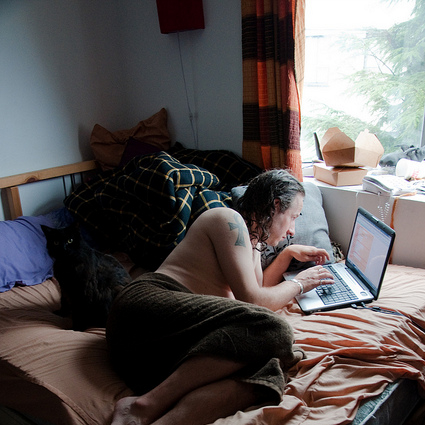

In [ ]:
# here's a sample stimulus (stimulus 0)
benchmark.view_sample_stimulus(0)

Constructing target RDMs in this case requires simply specifying a set of grouping_variables (*group_vars*) -- whatever is available in the benchmark metadata. In this case, we'll create one RDM per ROI per subject.

In [ ]:
# here are the various grouping_variables we could use from the metadata
print(benchmark.metadata.columns.to_list())

['subj_id', 'roi_name', 'roi_voxel_idx', 'voxel_reliability', 'roi_group', 'roi_level']


In [ ]:
# while the neural_data loads with a default set of RDMs,
# here we'll overwrite these with our own
benchmark.rdms = benchmark.get_rdms(group_vars = ['roi_name', 'subj_id'])

# note, we also want to save the indices associated with the responses
# that constitute each RDM, so we can parse the predicted responses
# in our neural encoding procedure (for voxel-encoding RSA)
benchmark.rdm_indices = benchmark.get_rdm_indices(['roi_name','subj_id'])

Having instantiated our neural data, we'll now 'instrumentalize' a deep neural network model to predict this data. In this example, we'll use a CLIP model, but there are a wide number of other options available in this repo.

In [ ]:
# functions for loading models
sys.path.append('model_opts')
from model_options import *

In [ ]:
# here's a sample of the models we've preprocessed for easy use.
list(get_model_options(model_source = 'timm').keys())[::21]

['botnet26t_256_classification',
 'dla169_classification',
 'hrnet_w64_classification',
 'pit_b_224_classification',
 'seresnet50_classification',
 'visformer_small_classification',
 'cait_xxs24_224_random',
 'eca_nfnet_l1_random',
 'jx_nest_small_random',
 'pit_ti_224_random',
 'skresnet18_random',
 'vit_small_patch16_224_random',
 'resnetv2_101x3_bitm_big_transfer',
 'ssl_resnet50_semi-supervised',
 'tf_efficientnet_b7_ap_adversarial']

In [ ]:
# to use the clip model, we need to install CLIP
!pip install -q git+https://github.com/openai/CLIP.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.2 MB/s eta 0:00:00


This pipeline requires a few things for the models we want to test. It requires some **metadata** (the name of the model, what it's been trained on, what class of model it is); a **call** for loading the model; and (perhaps most importantly of all) the appropriate **image transforms** that'll convert our stimulus images into the right format (and distribution) for our model.

So long as you have a PyTorch model, a torchvision *transforms.Compose()* function, and a *model_string*, *model_name*, and *train_type*, you can use any model at your disposal, simply modifying the pipeline below without the *get_model_options()* function.

In [ ]:
model_string = 'ViT-B/32_clip'
model_option = get_model_options()[model_string]

image_transforms = get_recommended_transforms(model_string)
model = eval(model_option['call'])
model = model.eval()
if torch.cuda.is_available():
  model = model.cuda()

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 62.1MiB/s]


With our neural data instantiated, and model instrumentalized, we now begin the process of feature extraction. To do this, we first select our target layers (though in reality, you'll usually want to test all layers). We then hook the features from these target layers as we pass batches of images through the model.  Then (for computational tractability), we reduce the dimensionality of these features (using in this case a technique called sparse random projection).

In [ ]:
# tools for feature extraction
sys.path.append('model_opts')
from feature_extraction import *

In [ ]:
stimulus_loader = DataLoader(StimulusSet(benchmark.stimulus_data.image_path, image_transforms), batch_size = 64)
# this function creates a dataloader using the stimulus_data dataframe of our neural benchmark,
# and the image_transforms we loaded when we instrumentalized our model.

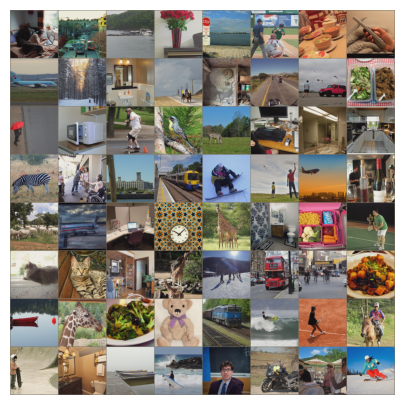

In [ ]:
# here's a sample of the dataloader (with the transforms reversed)
from model_opts_utils import *
get_dataloader_sample(stimulus_loader, nrow = 8)

In [ ]:
# to get the names of the model layers we'll subselect from, we'll use a convenience function
# because we're testing a vision transformer, we'll then extract every 5th linear layer.
model_layers = get_empty_feature_maps(model, stimulus_loader, names_only = True)
target_layers = [layer for layer in model_layers if 'Linear' in layer
                 and int(layer.split('-')[1]) % 5 == 1] + ['Vision-Transformer-1']

In [ ]:
# once we've selected our target layers, we pass these, our model, and our dataloader through a convenience function:
feature_maps = get_all_feature_maps(model, stimulus_loader, layers_to_retain = target_layers)

Feature Extraction (Batch):   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# here are the dimensionalities of our extracted features
# obviously, these take up a lot of RAM!
for feature_map in feature_maps:
  print(feature_map, feature_maps[feature_map].shape)

Linear-1 (1000, 153600)
Linear-6 (1000, 38400)
Linear-11 (1000, 153600)
Linear-16 (1000, 38400)
Linear-21 (1000, 153600)


In [ ]:
# tools for dimensionality reduction
sys.path.append('model_opts')
from feature_reduction import *

In [ ]:
# we'll now pass our extracted feature maps (along with a model_string to save temporary files)
# through another convenience function, with parameters for the sparse random projection.
# after reducing its dimensionality, we delete the full-sized feature_map with the keep_ argument
feature_maps_redux = srp_extraction(model_string, feature_maps = feature_maps, eps = 0.1, seed = 0,
                                    delete_original_feature_maps = True, upsampling=False)

SRP Extraction (Layer):   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# here are the dimensionalities of our reduced feature_maps
for feature_map in feature_maps_redux:
  print(feature_map, feature_maps_redux[feature_map].shape)

Linear-1 (1000, 5920)
Linear-6 (1000, 5920)
Linear-11 (1000, 5920)
Linear-16 (1000, 5920)
Linear-21 (1000, 5920)


Having extracted our target features and reduced their dimensionality, we now move to the bulk of the analysis: the mapping of deep net features to the brain data. In this example, we consider two mapping metrics: classic representational similarity analysis and reweighted (voxel-wise encoding) representational similarity analysis.

The first of these methods involves calculating RDMs (built with the 1 - Pearson distance) directly from each feature space, then comparing these directly to the target RDMs with a second-order (1 - Pearson) distance metric.

The second of these methods involves first fitting an encoding model per voxel per feature space -- effectively regressing the features of a given model layer onto the activation profile of a target voxel. With these encoding models, we can generate predicted activity per voxel, and use this predicted activity to build predicted (voxel-reweighted) RDMs, which we subsequently compare with tthe second (1 - Pearson) distance metric to the relevant brain RDMs.

These two metric are comparable, but make different assumptions about the nature of the information that undergirds the similarity between brain and machine. Keep this in mind if comparing the two side by side!

In [ ]:
# tools for mapping deep nets to brains
# and also for some pretty plotting
sys.path.append('model_opts')
from mapping_methods import *
from ridge_gcv_mod import RidgeCVMod

from plotnine import *
from plotnine import options
options.figure_size = (10,5)

In [ ]:
# here, we define some convenience functions for splitting our data into train and test sets
from sklearn.preprocessing import StandardScaler

def get_splithalf_xy(feature_map, response_data, scaling = StandardScaler()):
    data_splits = {'train': {}, 'test': {}}

    data_splits['train']['X'] = scaling.fit_transform(feature_map[::2,:])
    data_splits['test']['X'] = scaling.transform(feature_map[1::2,:])

    response_data = response_data.to_numpy()
    data_splits['train']['y'] = response_data[:,::2]
    data_splits['test']['y'] = response_data[:,1::2]

    return data_splits

def get_splithalf_rdms(rdms):
    split_rdms = {}
    for roi_name in rdms:
        split_rdms[roi_name] = {}
        for subj_id in rdms[roi_name]:
            split_rdms[roi_name][subj_id] = {'train': rdms[roi_name][subj_id][::2,::2],
                                            'test': rdms[roi_name][subj_id][1::2,1::2]}

    return split_rdms

In [ ]:
#@title Run this for RidgeGCV Code

import numpy as np

from sklearn.linear_model._ridge import LinearModel, MultiOutputMixin, RegressorMixin
from sklearn.linear_model._ridge import _RidgeGCV, _BaseRidgeCV, RidgeCV
from sklearn.linear_model._ridge import is_classifier, check_scoring, _check_gcv_mode
from sklearn.linear_model._ridge import _IdentityRegressor, safe_sparse_dot

from sklearn.linear_model._base import _preprocess_data, _rescale_data

from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr, spearmanr

pearsonr_vec = np.vectorize(pearsonr, signature='(n),(n)->(),()')

def pearson_r_score(y_true, y_pred, multioutput=None):
    y_true_ = y_true.transpose()
    y_pred_ = y_pred.transpose()
    return(pearsonr_vec(y_true_, y_pred_)[0])

class _RidgeGCVMod(_RidgeGCV):
    """Ridge regression with built-in Leave-one-out Cross-Validation."""

    def __init__(
        self,
        alphas=(0.1, 1.0, 10.0),
        *,
        fit_intercept=True,
        scoring=None,
        copy_X=True,
        gcv_mode=None,
        store_cv_values=False,
        is_clf=False,
        alpha_per_target=False,
    ):
        self.alphas = np.asarray(alphas)
        self.fit_intercept = fit_intercept
        self.scoring = scoring
        self.copy_X = copy_X
        self.gcv_mode = gcv_mode
        self.store_cv_values = store_cv_values
        self.is_clf = is_clf
        self.alpha_per_target = alpha_per_target

    def fit(self, X, y, sample_weight=None):
        _normalize = False

        X, y = self._validate_data(
            X,
            y,
            accept_sparse=["csr", "csc", "coo"],
            dtype=[np.float64],
            multi_output=True,
            y_numeric=True,
        )

        # alpha_per_target cannot be used in classifier mode. All subclasses
        # of _RidgeGCV that are classifiers keep alpha_per_target at its
        # default value: False, so the condition below should never happen.
        assert not (self.is_clf and self.alpha_per_target)

        if sample_weight is not None:
            sample_weight = _check_sample_weight(sample_weight, X, dtype=X.dtype)

        if np.any(self.alphas <= 0):
            raise ValueError(
                "alphas must be strictly positive. Got {} containing some "
                "negative or null value instead.".format(self.alphas)
            )

        X, y, X_offset, y_offset, X_scale = _preprocess_data(
            X,
            y,
            self.fit_intercept,
            _normalize,
            self.copy_X,
            sample_weight=sample_weight,
        )

        gcv_mode = _check_gcv_mode(X, self.gcv_mode)

        if gcv_mode == "eigen":
            decompose = self._eigen_decompose_gram
            solve = self._solve_eigen_gram
        elif gcv_mode == "svd":
            if sparse.issparse(X):
                decompose = self._eigen_decompose_covariance
                solve = self._solve_eigen_covariance
            else:
                decompose = self._svd_decompose_design_matrix
                solve = self._solve_svd_design_matrix

        n_samples = X.shape[0]

        if sample_weight is not None:
            X, y = _rescale_data(X, y, sample_weight)
            sqrt_sw = np.sqrt(sample_weight)
        else:
            sqrt_sw = np.ones(n_samples, dtype=X.dtype)

        X_mean, *decomposition = decompose(X, y, sqrt_sw)

        if self.scoring not in ['pearson_r', 'explained_variance']:
            raise ValueError("modified RidgeCV scoring requires one of ['pearson_r','explained_variance']")

        n_y = 1 if len(y.shape) == 1 else y.shape[1]
        n_alphas = 1 if np.ndim(self.alphas) == 0 else len(self.alphas)

        if self.store_cv_values:
            self.cv_values_ = np.empty((n_samples * n_y, n_alphas), dtype=X.dtype)

        best_coef, best_score, best_alpha = None, None, None

        for i, alpha in enumerate(np.atleast_1d(self.alphas)):
            G_inverse_diag, c = solve(float(alpha), y, sqrt_sw, X_mean, *decomposition)
            predictions = y - (c / G_inverse_diag)
            if self.store_cv_values:
                self.cv_values_[:, i] = predictions.ravel()

            identity_estimator = _IdentityRegressor()
            if self.alpha_per_target:
                if self.scoring == 'pearson_r':
                    alpha_score = pearson_r_score(y, predictions)
                if self.scoring == 'explained_variance':
                    alpha_score = explained_variance_score(y, predictions, multioutput = 'raw_values')
            else:
                if self.scoring == 'pearson_r':
                    alpha_score = pearson_r_score(y, predictions).mean()
                if self.scoring == 'explained_variance':
                    alpha_score = explained_variance_score(y, predictions, multioutput = 'uniform_average')

            # Keep track of the best model
            if best_score is None:
                if self.alpha_per_target and n_y > 1:
                    best_coef = c
                    best_score = np.atleast_1d(alpha_score)
                    best_alpha = np.full(n_y, alpha)
                else:
                    best_coef = c
                    best_score = alpha_score
                    best_alpha = alpha
            else:
                if self.alpha_per_target and n_y > 1:
                    to_update = alpha_score > best_score
                    best_coef[:, to_update] = c[:, to_update]
                    best_score[to_update] = alpha_score[to_update]
                    best_alpha[to_update] = alpha
                elif alpha_score > best_score:
                    best_coef, best_score, best_alpha = c, alpha_score, alpha

        self.alpha_ = best_alpha
        self.best_score_ = best_score
        self.dual_coef_ = best_coef
        self.coef_ = safe_sparse_dot(self.dual_coef_.T, X)

        X_offset += X_mean * X_scale
        self._set_intercept(X_offset, y_offset, X_scale)

        if self.store_cv_values:
            if len(y.shape) == 1:
                cv_values_shape = n_samples, n_alphas
            else:
                cv_values_shape = n_samples, n_y, n_alphas
            self.cv_values_ = self.cv_values_.reshape(cv_values_shape)

        return self


class _BaseRidgeCVMod(_BaseRidgeCV):
    def fit(self, X, y, sample_weight=None):
        cv = self.cv
        if cv is None:
            estimator = _RidgeGCVMod(
                self.alphas,
                fit_intercept=self.fit_intercept,
                scoring=self.scoring,
                gcv_mode=self.gcv_mode,
                store_cv_values=self.store_cv_values,
                is_clf=is_classifier(self),
                alpha_per_target=self.alpha_per_target,
            )
            estimator.fit(X, y, sample_weight=sample_weight)
            self.alpha_ = estimator.alpha_
            self.best_score_ = estimator.best_score_
            if self.store_cv_values:
                self.cv_values_ = estimator.cv_values_
        else:
            if self.store_cv_values:
                raise ValueError("cv!=None and store_cv_values=True are incompatible")
            if self.alpha_per_target:
                raise ValueError("cv!=None and alpha_per_target=True are incompatible")
            parameters = {"alpha": self.alphas}
            solver = "sparse_cg" if sparse.issparse(X) else "auto"
            model = RidgeClassifier if is_classifier(self) else Ridge
            gs = GridSearchCV(
                model(
                    fit_intercept=self.fit_intercept,
                    solver=solver,
                ),
                parameters,
                cv=cv,
                scoring=self.scoring,
            )
            gs.fit(X, y, sample_weight=sample_weight)
            estimator = gs.best_estimator_
            self.alpha_ = gs.best_estimator_.alpha
            self.best_score_ = gs.best_score_

        self.coef_ = estimator.coef_
        self.intercept_ = estimator.intercept_
        self.n_features_in_ = estimator.n_features_in_
        if hasattr(estimator, "feature_names_in_"):
            self.feature_names_in_ = estimator.feature_names_in_

        return self


class RidgeCVMod(MultiOutputMixin, RegressorMixin, _BaseRidgeCVMod):
    """Ridge regression with built-in cross-validation."""


In [ ]:
# let's define our main function here; we'll use this to get results
def get_benchmarking_results(feature_maps_redux, model_option):

  # information about the model to save in our scoresheets
  model_name = model_option['model_name']
  train_type = model_option['train_type']

  # here, we begin the scoring procedure, first defining which metrics we want to save
  scoresheet_lists = {metric: [] for metric in ['crsa','srpr','wrsa']}

  #we now loop through all our target_layers, scoring each as we go
  for model_layer_index, model_layer in enumerate(tqdm(feature_maps_redux, desc = 'Mapping (Layer)')):
      xy = get_splithalf_xy(feature_maps_redux[model_layer], benchmark.response_data)

      # these are the value of the lambda penalty in the ridge regression
      alpha_values = np.logspace(-1,5,7).tolist()

      # this is the regression that maps the feature space to the voxels.
      # it's a multioutput regression, so it fits all voxels simultaneously.
      # it automatically performs leave one out cross-validation ...
      # ... to choose the optimal lambda penalty. we save this loocv score
      # ... as the predictive score for the training set, but also ...
      # ... evaluate the optimal lambda regression on a heldout test set.
      regression = RidgeCVMod(alphas=alpha_values, store_cv_values = True,
                              alpha_per_target = True, scoring = 'pearson_r')

      # here's where we extract the optimal lambda and generate the test predictions
      regression.fit(xy['train']['X'], xy['train']['y'].transpose())
      best_alpha_idx = np.array([alpha_values.index(alpha_) for alpha_ in regression.alpha_])
      predictions = {'train': np.take_along_axis(regression.cv_values_, best_alpha_idx[None,:,None], axis = 2)[:,:,0],
                      'test': xy['test']['X'].dot(regression.coef_.transpose()) + regression.intercept_}

      for metric in scoresheet_lists:

          if metric == 'crsa':
              # even though the classic rsa metric is nonparametric
              # it's still wise to split into a train / test set
              # for the purposes of selecting the maximally correspondent layers
              splithalf_rdms = get_splithalf_rdms(benchmark.rdms)
              model_rdms = {'train': 1 - np.corrcoef(feature_maps_redux[model_layer][::2,:]),
                            'test': 1 - np.corrcoef(feature_maps_redux[model_layer][1::2,:])}

              for score_set in ['train', 'test']:
                  for roi_name in benchmark.rdms:
                      for subj_id in benchmark.rdms[roi_name]:
                          target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                          score = compare_rdms(model_rdms[score_set], target_rdm)
                          # what we've done in the lines above is loop through all
                          # possible [ROI][subj_id] RDMs and compared them to the layer RDM

                          # we save this score and other data in a dictionary
                          # for later aggregation in a scoresheet
                          scoresheet = {'score': score,
                                        'score_set': score_set,
                                        'roi_name': roi_name,
                                        'subj_id': subj_id,
                                        'model': model_name,
                                        'train_type': train_type,
                                        'model_layer': model_layer,
                                        'model_layer_index': model_layer_index,
                                        'distance_1': 'pearson_r',
                                        'distance_2': 'pearson_r'}

                          scoresheet_lists['crsa'].append(scoresheet)

          if metric == 'srpr':
              # we can, if we want, save the predictive scores per voxel
              # prior to aggregating the voxelwise predictions in an RDM
              for score_set in ['train','test']:
                  if score_set == 'train':
                      y = xy['train']['y'].transpose()
                      y_pred = predictions['train']
                  if score_set == 'test':
                      y = xy['test']['y'].transpose()
                      y_pred = predictions['test']
                  score = score_func(y, y_pred)

                  neuroid_ids = benchmark.response_data.index
                  # notice in this dictionary that we're saving a score per voxel
                  # individual units we occasionally called 'neuroids',
                  # to have a general term across different brain units
                  scoresheet = pd.DataFrame({benchmark.index_name: neuroid_ids,
                                              'score': score,
                                              'alpha': regression.alpha_.mean(),
                                              'score_set': score_set,
                                              'score_type': 'pearson_r',
                                              'model': model_name,
                                              'train_type': train_type,
                                              'model_layer': model_layer,
                                              'model_layer_index': model_layer_index})


                  scoresheet_lists['srpr'].append(scoresheet)

          if metric == 'wrsa':
              # now we perform the weighted rsa
              splifhalf_rdms = get_splithalf_rdms(benchmark.rdms)
              # the rdm_indices tell us which predictions
              # from the regression correspond to which voxel
              rdm_indices_dict = benchmark.rdm_indices

              for score_set in ['train', 'test']:
                  for roi_name in benchmark.rdms:
                      for subj_id in benchmark.rdms[roi_name]:
                          # again we iterate through all [ROI][subj_id] combos ...
                          # aggregating the responses from the fitted regression
                          # into the relevant predicted RDMs we compare to actual RDMS
                          rdm_indices = rdm_indices_dict[roi_name][subj_id]
                          prediction_subset = predictions[score_set][:,rdm_indices]
                          model_rdm = 1 - np.corrcoef(prediction_subset)
                          target_rdm = splithalf_rdms[roi_name][subj_id][score_set]
                          score = compare_rdms(model_rdm, target_rdm)

                          # this scoresheet should be identical in its dimensionality
                          # and composition to the crsa scoresheet
                          scoresheet = {'score': score,
                                        'score_set': score_set,
                                        'alpha': regression.alpha_.mean(),
                                        'roi_name': roi_name,
                                        'subj_id': subj_id,
                                        'model': model_name,
                                        'train_type': train_type,
                                        'model_layer': model_layer,
                                        'model_layer_index': model_layer_index,
                                        'distance_1': 'pearson_r',
                                        'distance_2': 'pearson_r'}

                          scoresheet_lists['wrsa'].append(scoresheet)

  # now, we concatenate our various results into easily accessible dataframes
  # adding relevant bits of metadata for group_by operations
  prime_metadata = benchmark.metadata[['roi_name','subj_id']]

  results = {}

  for metric in scoresheet_lists:
    if 'rsa' in metric:
        results[metric] = pd.DataFrame(scoresheet_lists[metric])
    if 'srpr' in metric:
        results[metric] = pd.concat(scoresheet_lists[metric]).merge(prime_metadata)

  return results

In [ ]:
# let's run the function, and get our results
results = get_benchmarking_results(feature_maps_redux, model_option)

#del feature_maps_redux # save some space; we won't need these anymore

Mapping (Layer):   0%|          | 0/5 [00:00<?, ?it/s]

MergeError: ignored

After fitting our regressions and computing the relevant representational similarities, we can now visualize the scores for individual ROIs across model layer, simultaneously scrutinizing the drop in generalization from training to test set (if in fact there is one).

In [ ]:
(ggplot(results['crsa'], aes('model_layer_index', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + theme_bw())

In [ ]:
(ggplot(results['wrsa'], aes('model_layer_index', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_point() + geom_line() + facet_wrap('~score_set') + theme_bw())

And there we have it! You've just benchmarked a CLIP model on the NSD data. Obviously, there are many more combinations you could try and different aggregates of the mappings you could scrutinize, but we leave this to you.

#### Feeling limited by vision? Try a language model!

In [ ]:
# for this, we'll need the sentence_transformers package
!pip install --quiet sentence_transformers

In [ ]:
# the following loads an SBERT model to process
# the coco captions associated with the images
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
model = model.eval()
if torch.cuda.is_available():
  model = model.cuda()

In [ ]:
# each coco image in the NSD stimulus set has 5 or 6 captions
# here, we concatenate them into a lsit
all_captions = [eval(caption_list) for caption_list in benchmark.stimulus_data.coco_captions]

In [ ]:
# now, we pass them through the SBERT model,
# and get an average embedding across the 5 captions per image
text_feature_list = []
for i in tqdm(range(5)):
    captions = [captions_list[i] for captions_list in all_captions]
    text_feature_list.append(model.encode(captions))

text_features = np.stack(text_feature_list, axis = 0).mean(axis = 0)

In [ ]:
# then we, can pass these text features through our SRP extractor:
feature_maps = get_feature_map_srps({'SBert-Output': text_features})

In [ ]:
# this gives us an output of the following dimensions
feature_maps['SBert-Output'].shape

In [ ]:
# here, since we don't have SBERT instrumentalized
# we make a simple metadata dict for our benchmarking
model_option = {'model_name': 'SBert',
                'train_type': 'MaskedLM'}

results = get_benchmarking_results(feature_maps, model_option)

In [ ]:
(ggplot(results['crsa'], aes('roi_name', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_col() + facet_wrap('~score_set') + theme_bw() + coord_flip())

In [ ]:
(ggplot(results['wrsa'], aes('roi_name', 'score', color = 'roi_name', group = 'roi_name')) +
 geom_col() + facet_wrap('~score_set') + theme_bw() + coord_flip())

As is evident, effectively the same process we used above can be easily repurposed for any number of feature spaces: language models included. Interestingly, we see that language embeddings do remarkable well in predicting selective cortex, but quite poorly in early visual cortex...

 ### Using Deep Dive in Decoding: Object Identity Decoding



In [ ]:
%cd ../DeepDive

Brain activity is of course not the only reasonable target for deep dive paradigms. What if we're interested in behavioral activity, or some kind of psychological benchmark we consider latent to a given network's learned features?

As it turns out, we can use effectively the same pipeline we used above to create encoding models of the brain, to create decoding models for any number of psychological phenomena. As a simple case, let's look to the SimpleShapes Dataset, a set of simple geometric objects with randomized texture meant to deisgned for pedagogy's sake and to explore the shape / texture tradeoff in deep net recognition capabilities.

In [ ]:
# the next few cells are a series of imports
# and a downloading of the image data
import os, sys, shutil
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from glob import glob
from plotnine import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm

In [ ]:
sys.path.append('deepdive')
from model_options import *
from feature_extraction import *
from feature_reduction import *

In [ ]:
!gdown https://drive.google.com/uc?id=10WzhgUaRRZMQ9rm020ApZHhq6GvNLZoe
!tar xfj simple_shapes.bz2

The SimpleShapes dataset consists of 6 objects, randomly placed, rotated and texturized.

In [ ]:
images = [plt.imread(f"SimpleShapes/00001{i}.jpg") for i in ['Cube', 'Sphere', 'Cylinder', 'Cone', 'Torus', 'Suzanne']]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for img, ax in zip(images, axes.flat):
    ax.imshow(img)
    ax.axis('off')

First things first, we'll need to put our image data in a data frame, which at minimum consists of the path to each stimulus, and (in decoding-type assays) a label for the stimulus. Additionally information, like group-indices, might also be appended.

In [ ]:
assets = glob('SimpleShapes/*.jpg') # glob all our image files

dictlist = [] # running list of rows
for asset in assets:

    # loop through the filenames and extract
    # indices and labels:
    imgstr = asset.split('/')[1]
    index = imgstr[:5]
    item = imgstr[5:imgstr.rfind('.')]

    # add these to a dictionary:
    row = {'image_path': asset, 'image_name': imgstr,
           'image_index': int(index), 'label': item}

    # append dictionary to running list of rows
    dictlist.append(row)

# create a dataframe from our list of
label_df = pd.DataFrame(dictlist)
label_df = label_df.query('image_index <= 500').reset_index()

Once we've aggregated together our stimulus data, we need to split it somehow into a training and testing set, to make sure any decoding model we fit can properly generalize to unseen stimuli.

Here's a train-test-split we perform manually to ensure equal numbers of objects in each category.

In [ ]:
from sklearn.model_selection import train_test_split

# save all our target dataset sizes
train_size, eval_size = 400, 100

# split the indices in our dataset into training and test
all_indices = list(range(1, train_size + eval_size))
test_indices = train_test_split(all_indices, test_size = eval_size)[1]
label_df['test_set'] = pd.to_numeric(label_df['image_index']).isin(test_indices)

# confirm our splitting produced even quantities
print('Proportion of Labels in Training / Eval')
print(label_df.groupby(['test_set'])['label'].value_counts())

Now, we begin the feature extraction. As above, we'll first load and instrumentalize our model, installing whatever packages we need to load it.

In [ ]:
sys.path.append('model_opts')
from feature_extraction import *

In [ ]:
!pip install -q git+https://github.com/openai/CLIP.git

In [ ]:
model_string = 'ViT-B/32_clip'
model_option = get_model_options()[model_string]
model_name = model_option['model_name']
train_type = model_option['train_type']

image_transforms = get_recommended_transforms(model_string)
model = eval(model_option['call'])
model = model.eval()
if torch.cuda.is_available():
  model = model.cuda()

Next, we'll create a dataloader to feed both our images (train and test) into our feature extraction algorithm. **Importantly!** We must again ensure that our dataloader does not scramble the order of images, which we must keep to link them again to the metadata after feature extraction.

In [ ]:
stimulus_loader = DataLoader(StimulusSet(label_df.image_path, image_transforms), batch_size = 64)
get_dataloader_sample(stimulus_loader, nrow = 8)

Because again, we're RAM-limited, we'll only select a subset of the layers: Linear layers 6,12,18, and 24 -- for a nice subsample of the hierarchy.

In [ ]:
model_layers = get_empty_feature_maps(model, stimulus_loader, names_only = True)
target_layers = [layer for layer in model_layers if 'Linear' in layer
                 and int(layer.split('-')[1]) % 6 == 0]

Now, we extract the features, immediately reducing their dimensionality to make them more manageable.

In [ ]:
feature_maps = get_all_feature_maps(model, stimulus_loader, remove_duplicates = False,
                                    layers_to_retain = target_layers)

In [ ]:
for feature_map in feature_maps:
  print(feature_map, feature_maps[feature_map].shape)

In [ ]:
feature_maps_redux = srp_extraction(model_string, feature_maps = feature_maps, eps = 0.1, seed = 0,
                                    delete_original_feature_maps = True)

With that done, we need a couple more infrastructural functions that will facilitate the matching of image and label, and the scoring of the decoding model. Our main functions in this will be *prepare_xy* for splitting our image data and features according to our predefined splits, and *parse_performance*, which will facilitate scoring.



In [ ]:
from sklearn.preprocessing import scale

def prepare_xy(image_df, predictors, label_col = 'Label', test_set_col = 'TestSet', scale_x = False):
    y, y_code = pd.factorize(image_df[label_col])
    X = predictors if not scale_x else scale(predictors)

    y_test = y[image_df[test_set_col]]
    X_test = X[image_df[test_set_col]]
    y_train = y[~image_df[test_set_col]]
    X_train = X[~image_df[test_set_col]]

    return(X_train, y_train, X_test, y_test)

In [ ]:
def score_row(x):
    return 1 if x['response'] == x['groundtruth'] else 0

def parse_performance(image_df, y, y_pred, label_col = 'label', test_set_col = 'test_set'):
    new_image_df = image_df.query('{} == True'.format(test_set_col)).copy()
    _, y_code = pd.factorize(image_df[label_col])
    new_image_df['groundtruth'] = y_code[y]
    new_image_df['response'] = y_code[y_pred]
    new_image_df['correct'] = new_image_df.apply(lambda x: score_row(x), axis = 1)
    new_image_df = new_image_df.drop(['index',test_set_col], axis = 1)

    return(new_image_df)

We can use the same regression we used above, but this time as a generalized linear model with categorical outputs (multinomial classifier) rather than a standard linear model with continuous outputs.

In [ ]:
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report

scoresheet_list = [] # we'll store our performance metrics per layer in this list
for model_layer_index, model_layer in enumerate(tqdm(feature_maps_redux, desc = 'Mapping (Layer)')):
    X_train, y_train, X_test, y_test = prepare_xy(label_df, feature_maps_redux[model_layer],
                                                  label_col = 'label', test_set_col = 'test_set')

    alpha_values = np.logspace(-1,5,7).tolist()

    # notice, we're using the same optimized ridge regression as above, but
    # this time, we're using it as a multinomial generalized linear model
    regression = RidgeClassifierCV(alphas=alpha_values).fit(X_train, y_train)
    y_pred = regression.predict(X_test)
    performance = parse_performance(label_df, y_test, y_pred,
                                    label_col = 'label', test_set_col = 'test_set')

    performance.insert(0,'model_layer_index', model_layer_index + 1)
    performance.insert(0,'model_layer', model_layer)

    # append our performance register to a running list
    scoresheet_list.append(performance)

scoresheet = pd.concat(scoresheet_list)

Fit success! How did we do? Below is what we call a "classification report" and contains a variety of signal detection metrics both for individual class and overall accuracy.

In [ ]:
target_scoresheet = scoresheet.query('model_layer_index == 1')
print(classification_report(target_scoresheet['groundtruth'], target_scoresheet['response']))

Finally, we can scrutinize performance across layers.

In [ ]:
plot_data = scoresheet.groupby(['model_layer_index','label'])['correct'].mean().reset_index()
(ggplot(plot_data, aes('model_layer_index', 'correct', color = 'label')) +
 geom_point() + geom_line(aes(group = 'label')) +  ylim([0,1.0]) + theme_bw() +
 stat_summary(fun_y = np.mean, geom = 'point', color = 'black') +
 stat_summary(fun_y = np.mean, geom = 'line', color = 'black', size = 2.5))

And voilà times two. You've now fit a deep net decoding model. Happy benchmarking!